## Load Libraries and Create Function

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
%matplotlib inline

In [2]:
class BinaryClassificationPerformance():
    '''Performance measures to evaluate the fit of a binary classification model'''
    
    def __init__(self, predictions, labels, desc, probabilities=None):
        '''Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y'''
        '''probabilities-optional, probability that Y is equal to True'''
        self.probabilities = probabilities
        self.performance_df = pd.concat([pd.DataFrame(predictions), pd.DataFrame(labels)], axis=1)
        self.performance_df.columns = ['preds', 'labls']
        self.desc = desc
        self.performance_measures = {}
        self.image_indices = {}
  
    def compute_measures(self):
        '''Compute performance measures defined by Flach p. 57'''
        self.performance_measures['Pos'] = self.performance_df['labls'].sum()
        self.performance_measures['Neg'] = self.performance_df.shape[0] - self.performance_df['labls'].sum()
        self.performance_measures['TP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['TN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['Accuracy'] = (self.performance_measures['TP'] + self.performance_measures['TN']) / (self.performance_measures['Pos'] + self.performance_measures['Neg'])
        self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
        self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']

    def img_indices(self):
        '''Get the indices of true and false positives to be able to locate the corresponding images in a list of image names'''
        self.performance_df['tp_ind'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == True))
        self.performance_df['fp_ind'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == False))
        self.image_indices['TP_indices'] = np.where(self.performance_df['tp_ind']==True)[0].tolist()
        self.image_indices['FP_indices'] = np.where(self.performance_df['fp_ind']==True)[0].tolist()

In [3]:
amazon = pd.read_csv('raw_data_train.csv', encoding ='latin-1')
print(amazon.shape)

(364000, 14)


In [4]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      200885        266059  266060  B001E96JZG  A2FRQL9C1AI1DQ   
1      245479        377230  377231  B000EVT074  A2O3I88VXDCSM9   
2       18688        371070  371071  B000BXZ6FK   AXNR5JOUCMC3C   
3      383484        100644  100645  B003CGOFP0  A1MP1O8XIPTBL9   
4      258966        202625  202626  B001EO5TJ8  A1NA2IGTRDXPAM   

                        ProfileName  HelpfulnessNumerator  \
0                         sugarfoot                     1   
1  Daniel W. Abbott "Daniel Abbott"                     1   
2       James S. Ayers "Consumer X"                     3   
3                        Ctomlinson                     1   
4              Earl McKenney "Earl"                     3   

   HelpfulnessDenominator  Score        Time  \
0                       1      5  1299456000   
1                       1      5  1211155200   
2                       3      3  1194566400   
3                       2      5  1313

## Feature Extraction from Natural Language Libraries

In [5]:
# vectorize Bag of Words from review text; as sparse matrix
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
X_hv = hv.fit_transform(amazon.Text)
print(X_hv.shape)

(364000, 131072)


In [6]:
joblib.dump(hv, 'hv.pkl') # pickle

['hv.pkl']

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X_hv)

joblib.dump(transformer, 'transformer.pkl')

['transformer.pkl']

In [8]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


## Creating Additional Features

In [9]:
import re
from string import punctuation

# length features
amazon['reviewLen'] = amazon['Text'].str.len()
amazon['profileLen'] = amazon['ProfileName'].str.len() 
amazon['summaryLen'] = amazon['Summary'].str.len() 

#count number of reviews made by the same reviewer
amazon['commCount'] = amazon.groupby('ProfileName')['ProfileName'].transform('count')

#Capital letter Features
amazon['profileCaps'] = amazon['ProfileName'][(np.isnan(amazon['profileLen'])) == 0].apply(lambda x: len(re.findall("[A-Z]", x)))
amazon['summaryCaps'] = amazon['Summary'][(np.isnan(amazon['summaryLen'])) == 0].apply(lambda x: len(re.findall("[A-Z]", x)))
amazon['reviewCaps'] = amazon['Text'][(np.isnan(amazon['reviewLen'])) == 0].apply(lambda x: len(re.findall("[A-Z]", x)))

#punctuation features
amazon['profilePunc'] = amazon['ProfileName'][(np.isnan(amazon['profileLen'])) == 0].apply(lambda x: len(list(filter(lambda c: c in punctuation, x))))
amazon['summaryPunc'] = amazon['Summary'][(np.isnan(amazon['summaryLen'])) == 0].apply(lambda x: len(list(filter(lambda c: c in punctuation, x))))
amazon['reviewPunc'] = amazon['Text'][(np.isnan(amazon['reviewLen'])) == 0].apply(lambda x: len(list(filter(lambda c: c in punctuation, x))))

#convert NaN's to 0
amazon['profileLen'][(np.isnan(amazon['profileLen']))] = 0
amazon['summaryLen'][(np.isnan(amazon['summaryLen']))] = 0
amazon['reviewLen'][(np.isnan(amazon['reviewLen']))] = 0
amazon['commCount'][(np.isnan(amazon['commCount']))] = 0
amazon['profileCaps'][(np.isnan(amazon['profileCaps']))] = 0
amazon['summaryCaps'][(np.isnan(amazon['summaryCaps']))] = 0
amazon['reviewCaps'][(np.isnan(amazon['reviewCaps']))] = 0
amazon['profilePunc'][(np.isnan(amazon['profilePunc']))] = 0
amazon['summaryPunc'][(np.isnan(amazon['summaryPunc']))] = 0
amazon['reviewPunc'][(np.isnan(amazon['reviewPunc']))] = 0

#Interactions
amazon['score_count'] = amazon['Score']*amazon['commCount']
amazon['len_count'] = amazon['reviewLen']*amazon['commCount']
amazon['score_len'] = amazon['Score']*amazon['reviewLen']

X_quant_features = amazon[['Score', 'reviewLen', 'Time', 'summaryLen', 'commCount', 'profileCaps', 'profileLen', 
                            'summaryCaps', 'reviewCaps', 'profilePunc', 'summaryPunc', 'reviewPunc', 'score_count', 'len_count', 'score_len']]
print(X_quant_features.head(10))
print(type(X_quant_features))

C:\Users\Julian Bautista\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Julian Bautista\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Julian Bautista\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Julian Bautista\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: SettingWithCopyWarning: 
A value is trying

   Score  reviewLen        Time  summaryLen  commCount  profileCaps  \
0      5        976  1299456000        58.0        2.0          0.0   
1      5         85  1211155200         6.0        1.0          5.0   
2      3        379  1194566400        25.0        1.0          5.0   
3      5        112  1313452800         3.0        2.0          1.0   
4      5        157  1168387200         3.0        9.0          4.0   
5      5        119  1350259200         5.0        3.0          3.0   
6      5       1360  1348531200        72.0      106.0          2.0   
7      4       2274  1261353600        42.0        2.0          3.0   
8      5       1508  1279756800        38.0        4.0          1.0   
9      5        178  1297728000        18.0        3.0          2.0   

   profileLen  summaryCaps  reviewCaps  profilePunc  summaryPunc  reviewPunc  \
0         9.0          4.0          18          0.0          3.0          22   
1        32.0          5.0           5          3.0       

In [10]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(364000, 131087)


In [11]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X_matrix)
print(X.shape)

joblib.dump(sc, 'sc.pkl') # pickle

(364000, 131087)


['sc.pkl']

In [12]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


## Create Models

In [13]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X, y)
joblib.dump(svm, 'svm.pkl') # pickle

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

{'TP': 13030, 'Neg': 337386, 'Pos': 26614, 'Recall': 0.4895919440895769, 'Accuracy': 0.9340357142857143, 'FP': 10427, 'Precision': 0.55548450355970502, 'FN': 13584, 'TN': 326959}


In [14]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
lgs.fit(X, y)
joblib.dump(lgs, 'lgs.pkl') # pickle

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

{'TP': 14335, 'Neg': 337386, 'Pos': 26614, 'Recall': 0.53862628691666037, 'Accuracy': 0.93431043956043958, 'FP': 11632, 'Precision': 0.55204682866715449, 'FN': 12279, 'TN': 325754}


In [15]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X, y)
joblib.dump(nbs, 'nbs.pkl') # pickle

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'TP': 16843, 'Neg': 337386, 'Pos': 26614, 'Recall': 0.63286240324641163, 'Accuracy': 0.86448351648351651, 'FP': 39557, 'Precision': 0.29863475177304966, 'FN': 9771, 'TN': 297829}


In [16]:
# MODEL: Ridge Regression Classifier
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X, y)
joblib.dump(rdg, 'rdg.pkl') # pickle

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'TP': 7996, 'Neg': 337386, 'Pos': 26614, 'Recall': 0.30044337566694224, 'Accuracy': 0.94725549450549451, 'FP': 581, 'Precision': 0.93226069721347793, 'FN': 18618, 'TN': 336805}


In [17]:
# MODEL: Perceptron
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X, y)
joblib.dump(prc, 'prc.pkl') # pickle

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

{'TP': 12795, 'Neg': 337386, 'Pos': 26614, 'Recall': 0.4807620049597956, 'Accuracy': 0.9345, 'FP': 10023, 'Precision': 0.56074151985274778, 'FN': 13819, 'TN': 327363}


In [20]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes = (1000))
nn.fit(X, y)
joblib.dump(nn, 'nn.pkl') # pickle

nn_performance = BinaryClassificationPerformance(nn.predict(X), y, 'nn')
nn_performance.compute_measures()
print(nn_performance.performance_measures)

C:\Users\Julian Bautista\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:565: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

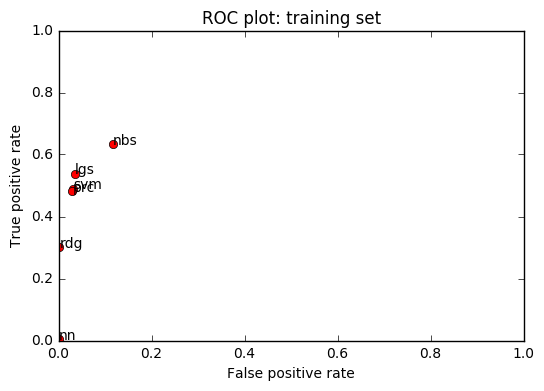

In [19]:
fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance, nn_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()